In [1]:
import pandas as pd
from chromax import Simulator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from random import choice
from typing import Dict, Any, List
import torch.optim as optim


In [2]:
# Init

def init_program():
    number_individuals = 50  # Replace with your actual number of individuals
    number_markers = 100     # Replace with your actual number of markers
    ploidy = 2              # Replace with your actual ploidy level
    batch_size = 3
    initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
    #printshape('first pop shape' , initial_population)
    genetic_map_df = create_fake_geneticmap(number_markers)
    marker_strength = np.array(genetic_map_df['Yield'])
    fraction_selection = 10

    #score init pop
    initial_score = np.array([calculate_scores(x,marker_strength) for x in initial_population])
    #printshape('first score list shape' , initial_score)

    #score2hist(initial_score)

    return initial_population, initial_score, genetic_map_df, marker_strength

def create_fake_geneticmap(number_markers:int):
    """The genetic map represents the rules of the game. It assigns the truth value to each marker.

    :param number_markers: the total number of markers to include in this genetic map. must correspond to population shape
    :type number_markers: int 
    """
    # 'chr' will always be '1A' for every marker
    chr_array = ['1A'] * number_markers
    
    # 'yield': Create a marker_strength array with 1 float between -0.5 and +0.5 randomly
    # yield_array = np.random.poisson(np.random.randint(1,10), size=number_markers)
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)

    # Scale the Poisson values to the range [0, 1]
    scaled_poisson_values = poisson_values / np.max(poisson_values)

    # Stretch and shift the values to the range [-1, 1]
    yield_array = (scaled_poisson_values * 2) - 1
    
    # 'cM': create an array for number_markers length evenly sampled between 0 and 100
    cM_array = np.linspace(0, 100, num=number_markers)
    
    # Create the DataFrame with the auto-generated data
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    
    return df

def create_fake_population(total_pops:int, number_individuals:int, number_markers:int, ploidy:int):
    """
        Creates a batch of populations. A populations is a group of individuals. An individual is composed of markers. Markers are 0 or 1

        Returns : binary array shape (total_pops, number_individuals, number_markers, ploidy)
    """
    # List of generation methods
    generation_methods = [
        lambda: np.random.randint(2, size=(number_individuals, number_markers, ploidy)),
        lambda: np.random.choice([0, 1], size=(number_individuals, number_markers, ploidy))
    ]
    
    populations = []
    for _ in range(total_pops):
        # Randomly select a generation method and generate the population
        gen_method = choice(generation_methods)
        population = gen_method()
        populations.append(population)
        
    # Combine all populations into a single numpy array
    combined_population = np.array(populations)

    return combined_population




def calculate_scores(population, marker_strength):
    """
    Calculates the additive score by matrix multipling the population (n,m) with the marker strengths (m,)
    """
    # Perform a dot product between the dosages and marker strength arrays
    dosages = np.sum(population,axis=2)
    scores = np.dot(dosages, marker_strength)
    return scores

def panmixia(selected_parents, total_offspring):
    """ Handles the random crossing for us ; heuristic!

    selected_parents ( n , m , d )
    
    """
    n, m, d = selected_parents.shape
    offspring_target = total_offspring
    offspring_list = []

    while len(offspring_list) < offspring_target:
        # Randomly pick two parents without replacement
        parents_indices = np.random.choice(n, size=2, replace=False)
        parent1, parent2 = selected_parents[parents_indices]

        # Simulate random recombination for each marker
        offspring = np.zeros((m, d), dtype=parent1.dtype)
        for i in range(m):
            # Randomly choose one allele from each parent for each marker
            for j in range(d):
                parent_allele = np.random.choice([parent1[i, j], parent2[i, j]])
                offspring[i, j] = parent_allele

        # Add the new offspring to the offspring list
        offspring_list.append(offspring)

    # Convert offspring list to a numpy array with shape (offspring_target, m, d)
    offspring_array = np.array(offspring_list)
    return offspring_array


def scores2parents(scores,K):
    """
    hint: use output from calculate_scores
    """
    # Specify the number of top values you want (K)
    K = 5

    # Get the indices that would sort the array
    sorted_indices = np.argsort(scores)

    # Take the last K indices of the sorted indices array
    top_k_indices = sorted_indices[-K:]

    # Since argsort returns indices in ascending order, reverse to get the top values
    top_k_indices = top_k_indices[::-1]

    print("Indices of top K values:", top_k_indices)
    print("Top K values:", scores[top_k_indices])

    return top_k_indices


def select_parents(policy, total_parents):
    """
        input: Policy from actor ( score or metric value for each individual )
        returns : index of parents to be included in random_crosses for next step of breeding program
    """
    # Use numpy's argsort function to get the indices of the top 'total_parents' values
    indices = np.argsort(policy)[-total_parents:]
    values = policy[indices]
    return values,indices

def printshape(message , arr):
    print(f'{message} {arr.shape}')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def score2hist(score, title='population score distribution'):
    #e.g. (3,50) array

    # Assuming 'data' is your (3,50) array
    data = score

    # Plot KDE for each row in the data
    for i in range(data.shape[0]):
        kde = gaussian_kde(data[i])
        dist_space = np.linspace(min(data[i]), max(data[i]), 100)
        plt.plot(dist_space, kde(dist_space), label=f'Distribution {i+1}')

    # Adding labels and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.title(title)

    # Show plot
    plt.show()


# Example usage:
number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3
initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
fraction_selection = 10

In [4]:
import numpy as np
import torch

def init_program(    number_individuals = 50,
    number_markers = 100,
    ploidy = 2,
    batch_size = 3):

    initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
    genetic_map_df = create_fake_geneticmap(number_markers)
    marker_strength = np.array(genetic_map_df['Yield'])
    fraction_selection = 10

    # Convert marker_strength to a PyTorch tensor
    marker_strength_tensor = torch.tensor(marker_strength, dtype=torch.float32)

    # Score the initial population
    initial_score = np.array([calculate_scores(torch.tensor(x, dtype=torch.float32), marker_strength_tensor).numpy() for x in initial_population])

    return initial_population, initial_score, genetic_map_df, marker_strength

# Make sure the calculate_scores function is defined correctly as shown in the previous response


In [5]:
# #random selection baseline

# initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# current_population = initial_population
# current_score = initial_score

# for _ in range(5):
#     #select random half of individuals in each pop
#     selected_parents = current_population[:,:25,:,:]
#     selected_parents_score = np.array([calculate_scores(x, marker_strength) for x in selected_parents])
#     new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in selected_parents])
#     new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
#     current_population = new_pop
#     current_score = new_score
#     score2hist(selected_parents_score, title='selected parents scores')

In [6]:
# #truncation selection baseline

# initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# current_population = initial_population
# current_score = initial_score

# frames = []
# for _ in range(5):
#     #select top half of individuals in each pop
#     truncation = [select_parents(x,int(initial_population.shape[1]/2)) for x in current_score]
#     parent_index = [x[1] for x in truncation]
#     parent_metric = [x[0] for x in truncation]
#     parent_pop = np.array([x[y] for x,y in zip(current_population, parent_index)])    
#     new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in parent_pop])
#     new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
#     current_population = new_pop
#     current_score = new_score
#     score2hist(current_score)
#     frames.append(current_score)

# frames = np.array(frames)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import kaiming_normal_

class ActorModel(nn.Module):
    def __init__(self, num_individual, num_markers, ploidy, use_skip_connection=False):
        super(ActorModel, self).__init__()
        
        self.use_skip_connection = use_skip_connection
        
        # Flatten layers for population and phenotype inputs
        self.flatten_population = nn.Flatten()
        self.flatten_phenotype = nn.Flatten()
        
        # Combined input size calculation
        combined_input_size = num_individual * num_markers * ploidy + num_individual
        
        # Define the hidden layers
        self.hidden1 = nn.Linear(combined_input_size, 64)
        self.hidden2 = nn.Linear(64, 64)
        
        # Define the output layer
        self.output = nn.Linear(64, num_individual)
        
        # Define the transformation layer for skip connection
        if use_skip_connection:
            self.phenotype_transform = nn.Linear(num_individual, 64)
        
        # Initialize weights using He initialization
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)
    
    def forward(self, population_input, phenotype_input):
        # Flatten inputs
        flat_population = self.flatten_population(population_input)
        flat_phenotype = self.flatten_phenotype(phenotype_input)
        
        # Combine inputs
        combined = torch.cat([flat_population, flat_phenotype], dim=1)
        
        # Hidden layers with ReLU activation
        hidden1 = F.relu(self.hidden1(combined))
        hidden2 = F.relu(self.hidden2(hidden1))
        
        # Check if skip connection is to be used
        if self.use_skip_connection:
            phenotype_transformed = F.relu(self.phenotype_transform(flat_phenotype))
            skip_connection = hidden2 + phenotype_transformed
            output = F.softmax(self.output(skip_connection), dim=1)
        else:
            output = F.softmax(self.output(hidden2), dim=1)
        
        return output


def calculate_scores(offspring, marker_tensor):
    # Sum the contributions from both sets of chromosomes (ploidy)
    summed_offspring = offspring.sum(dim=-1)  # This will sum across the ploidy dimension
    
    # Perform the dot product between the marker_tensor and the summed_offspring
    # We need to unsqueeze the marker_tensor to perform batch matrix multiplication
    marker_tensor_unsqueezed = marker_tensor.unsqueeze(0).unsqueeze(-1)
    
    # Perform batch matrix multiplication
    scores = torch.matmul(summed_offspring, marker_tensor_unsqueezed)
    
    # Remove the last dimension and squeeze the result to get the final scores
    scores = scores.squeeze(-1)
    
    return scores


def crossover(parents, num_offspring_per_population):
    num_populations, num_parents, num_markers, ploidy = parents.shape
    offspring = torch.empty((num_populations, num_offspring_per_population, num_markers, ploidy), dtype=torch.float32)

    for i in range(num_populations):
        for j in range(num_offspring_per_population):
            # Randomly select two parents
            parent_indices = torch.randperm(num_parents)[:2]
            parent1 = parents[i, parent_indices[0]]
            parent2 = parents[i, parent_indices[1]]

            # Perform single crossover
            crossover_point = torch.randint(low=1, high=num_markers, size=(1,)).item()
            child1 = torch.cat((parent1[:crossover_point, :], parent2[crossover_point:, :]), dim=0)
            child2 = torch.cat((parent2[:crossover_point, :], parent1[crossover_point:, :]), dim=0)

            # Randomly select one of the two possible offspring
            offspring[i, j] = child1 if torch.rand(1).item() < 0.5 else child2

    return offspring

# init the RL environment
initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# init the Agent
a = ActorModel(num_individual=initial_population.shape[1], num_markers = initial_population.shape[2], ploidy = initial_population.shape[3])

# prep for torch
population_tensor = torch.from_numpy(initial_population).float()
score_tensor = torch.from_numpy(initial_score).float()
score_tensor = score_tensor[:,0,:]
marker_tensor = torch.from_numpy(marker_strength).float()

# Perform the prediction
with torch.no_grad():
    prediction = a(population_tensor, score_tensor)

# Sample 25 individuals from each population
num_samples = 25
samples = torch.multinomial(prediction, num_samples, replacement=True)

# Create a tensor for the batch dimension which corresponds to each population
batch_indices = torch.arange(population_tensor.size(0)).unsqueeze(1).expand_as(samples)

# Use the batch_indices and samples to index into the initial_population tensor
selected_parents = population_tensor[batch_indices, samples]

# return: 50 offspring per population
offspring_geno = crossover(selected_parents, 50)
offspring_score = calculate_scores(offspring_geno, marker_tensor)

# Calculate the mean of each array along axis 1
offspring_score_mean = offspring_score.mean(dim=1, keepdim=True)
score_tensor_mean = score_tensor.mean(dim=1, keepdim=True)

# Subtract the offspring_score mean from the score_tensor mean
loss = offspring_score_mean - score_tensor_mean # WANT TO MAXIMIZE THIS !!! optimize

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import kaiming_normal_

class ActorModel(nn.Module):
    def __init__(self, num_individual, num_markers, ploidy, use_skip_connection=False):
        super(ActorModel, self).__init__()
        
        self.use_skip_connection = use_skip_connection
        
        # Flatten layers for population and phenotype inputs
        self.flatten_population = nn.Flatten()
        self.flatten_phenotype = nn.Flatten()
        
        # Combined input size calculation
        combined_input_size = num_individual * num_markers * ploidy + num_individual
        
        # Define the hidden layers
        self.hidden1 = nn.Linear(combined_input_size, 64)
        self.hidden2 = nn.Linear(64, 64)
        
        # Define the output layer
        self.output = nn.Linear(64, num_individual)
        
        # Define the transformation layer for skip connection
        if use_skip_connection:
            self.phenotype_transform = nn.Linear(num_individual, 64)
        
        # Initialize weights using He initialization
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Create a tensor with the same shape as the weight tensor,
                # filled with -1 or 1 randomly
                weight_shape = m.weight.size()
                random_weights = torch.randint(low=1, high=2, size=weight_shape).float() * 2 - 1
                m.weight.data = random_weights
                if m.bias is not None:
                    m.bias.data.fill_(0.01)
    
    def forward(self, population_input, phenotype_input):
        # Flatten inputs
        flat_population = self.flatten_population(population_input)
        flat_phenotype = self.flatten_phenotype(phenotype_input)
        
        # Combine inputs
        combined = torch.cat([flat_population, flat_phenotype], dim=1)
        
        # Hidden layers with ReLU activation
        hidden1 = F.relu(self.hidden1(combined))
        hidden2 = F.relu(self.hidden2(hidden1))
        
        # Check if skip connection is to be used
        if self.use_skip_connection:
            phenotype_transformed = F.relu(self.phenotype_transform(flat_phenotype))
            skip_connection = hidden2 + phenotype_transformed
            output = F.softmax(self.output(skip_connection), dim=1)
        else:
            output = F.softmax(self.output(hidden2), dim=1)
        
        return output


def calculate_scores(offspring, marker_tensor):
    # Sum the contributions from both sets of chromosomes (ploidy)
    summed_offspring = offspring.sum(dim=-1)  # This will sum across the ploidy dimension
    
    # Perform the dot product between the marker_tensor and the summed_offspring
    # We need to unsqueeze the marker_tensor to perform batch matrix multiplication
    marker_tensor_unsqueezed = marker_tensor.unsqueeze(0).unsqueeze(-1)
    
    # Perform batch matrix multiplication
    scores = torch.matmul(summed_offspring, marker_tensor_unsqueezed)
    
    # Remove the last dimension and squeeze the result to get the final scores
    scores = scores.squeeze(-1)
    
    return scores


def crossover(parents, num_offspring_per_population):
    num_populations, num_parents, num_markers, ploidy = parents.shape
    offspring = torch.empty((num_populations, num_offspring_per_population, num_markers, ploidy), dtype=torch.float32)

    for i in range(num_populations):
        for j in range(num_offspring_per_population):
            # Randomly select two parents
            parent_indices = torch.randperm(num_parents)[:2]
            parent1 = parents[i, parent_indices[0]]
            parent2 = parents[i, parent_indices[1]]

            # Perform single crossover
            crossover_point = torch.randint(low=1, high=num_markers, size=(1,)).item()
            child1 = torch.cat((parent1[:crossover_point, :], parent2[crossover_point:, :]), dim=0)
            child2 = torch.cat((parent2[:crossover_point, :], parent1[crossover_point:, :]), dim=0)

            # Randomly select one of the two possible offspring
            offspring[i, j] = child1 if torch.rand(1).item() < 0.5 else child2

    return offspring


In [9]:
# init the RL environment
initial_population, initial_score, genetic_map_df, marker_strength = init_program(number_markers=10)

# init the Agent
a = ActorModel(num_individual=initial_population.shape[1], num_markers = initial_population.shape[2], ploidy = initial_population.shape[3], use_skip_connection=False)
a.train()

# prep for torch
population_tensor = torch.from_numpy(initial_population).float().requires_grad_(True)
score_tensor = torch.from_numpy(initial_score).float().requires_grad_(True)
score_tensor = score_tensor[:, 0, :].requires_grad_(True)
marker_tensor = torch.from_numpy(marker_strength).float().requires_grad_(True)

optimizer = optim.Adam(a.parameters(), lr=0.0001)

losses = []


In [10]:
# Init

def init_program():
    number_individuals = 50  # Replace with your actual number of individuals
    number_markers = 100     # Replace with your actual number of markers
    ploidy = 2              # Replace with your actual ploidy level
    batch_size = 3
    initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
    #printshape('first pop shape' , initial_population)
    genetic_map_df = create_fake_geneticmap(number_markers)
    marker_strength = np.array(genetic_map_df['Yield'])
    fraction_selection = 10

    #score init pop
    initial_score = np.array([calculate_scores(x,marker_strength) for x in initial_population])
    #printshape('first score list shape' , initial_score)

    #score2hist(initial_score)

    return initial_population, initial_score, genetic_map_df, marker_strength

def create_fake_geneticmap(number_markers:int):
    """The genetic map represents the rules of the game. It assigns the truth value to each marker.

    :param number_markers: the total number of markers to include in this genetic map. must correspond to population shape
    :type number_markers: int 
    """
    # 'chr' will always be '1A' for every marker
    chr_array = ['1A'] * number_markers
    
    # 'yield': Create a marker_strength array with 1 float between -0.5 and +0.5 randomly
    # yield_array = np.random.poisson(np.random.randint(1,10), size=number_markers)
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)

    # Scale the Poisson values to the range [0, 1]
    scaled_poisson_values = poisson_values / np.max(poisson_values)

    # Stretch and shift the values to the range [-1, 1]
    yield_array = (scaled_poisson_values * 2) - 1
    
    # 'cM': create an array for number_markers length evenly sampled between 0 and 100
    cM_array = np.linspace(0, 100, num=number_markers)
    
    # Create the DataFrame with the auto-generated data
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    
    return df

def create_fake_population(total_pops:int, number_individuals:int, number_markers:int, ploidy:int):
    """
        Creates a batch of populations. A populations is a group of individuals. An individual is composed of markers. Markers are 0 or 1

        Returns : binary array shape (total_pops, number_individuals, number_markers, ploidy)
    """
    # List of generation methods
    generation_methods = [
        lambda: np.random.randint(2, size=(number_individuals, number_markers, ploidy)),
        lambda: np.random.choice([0, 1], size=(number_individuals, number_markers, ploidy))
    ]
    
    populations = []
    for _ in range(total_pops):
        # Randomly select a generation method and generate the population
        gen_method = choice(generation_methods)
        population = gen_method()
        populations.append(population)
        
    # Combine all populations into a single numpy array
    combined_population = np.array(populations)

    return combined_population




def calculate_scores(population, marker_strength):
    """
    Calculates the additive score by matrix multipling the population (n,m) with the marker strengths (m,)
    """
    # Perform a dot product between the dosages and marker strength arrays
    dosages = np.sum(population,axis=2)
    scores = np.dot(dosages, marker_strength)
    return scores

def panmixia(selected_parents, total_offspring):
    """ Handles the random crossing for us ; heuristic!

    selected_parents ( n , m , d )
    
    """
    n, m, d = selected_parents.shape
    offspring_target = total_offspring
    offspring_list = []

    while len(offspring_list) < offspring_target:
        # Randomly pick two parents without replacement
        parents_indices = np.random.choice(n, size=2, replace=False)
        parent1, parent2 = selected_parents[parents_indices]

        # Simulate random recombination for each marker
        offspring = np.zeros((m, d), dtype=parent1.dtype)
        for i in range(m):
            # Randomly choose one allele from each parent for each marker
            for j in range(d):
                parent_allele = np.random.choice([parent1[i, j], parent2[i, j]])
                offspring[i, j] = parent_allele

        # Add the new offspring to the offspring list
        offspring_list.append(offspring)

    # Convert offspring list to a numpy array with shape (offspring_target, m, d)
    offspring_array = np.array(offspring_list)
    return offspring_array


def scores2parents(scores,K):
    """
    hint: use output from calculate_scores
    """
    # Specify the number of top values you want (K)
    K = 5

    # Get the indices that would sort the array
    sorted_indices = np.argsort(scores)

    # Take the last K indices of the sorted indices array
    top_k_indices = sorted_indices[-K:]

    # Since argsort returns indices in ascending order, reverse to get the top values
    top_k_indices = top_k_indices[::-1]

    print("Indices of top K values:", top_k_indices)
    print("Top K values:", scores[top_k_indices])

    return top_k_indices


def select_parents(policy, total_parents):
    """
        input: Policy from actor ( score or metric value for each individual )
        returns : index of parents to be included in random_crosses for next step of breeding program
    """
    # Use numpy's argsort function to get the indices of the top 'total_parents' values
    indices = np.argsort(policy)[-total_parents:]
    values = policy[indices]
    return values,indices

def printshape(message , arr):
    print(f'{message} {arr.shape}')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def score2hist(score, title='population score distribution'):
    #e.g. (3,50) array

    # Assuming 'data' is your (3,50) array
    data = score

    # Plot KDE for each row in the data
    for i in range(data.shape[0]):
        kde = gaussian_kde(data[i])
        dist_space = np.linspace(min(data[i]), max(data[i]), 100)
        plt.plot(dist_space, kde(dist_space), label=f'Distribution {i+1}')

    # Adding labels and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.title(title)

    # Show plot
    plt.show()


# Example usage:
number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3
initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
fraction_selection = 10

In [11]:
import numpy as np
import torch

def init_program():
    number_individuals = 50  # Replace with your actual number of individuals
    number_markers = 100     # Replace with your actual number of markers
    ploidy = 2               # Replace with your actual ploidy level
    batch_size = 3
    initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
    genetic_map_df = create_fake_geneticmap(number_markers)
    marker_strength = np.array(genetic_map_df['Yield'])
    fraction_selection = 10

    # Convert marker_strength to a PyTorch tensor
    marker_strength_tensor = torch.tensor(marker_strength, dtype=torch.float32)

    # Score the initial population
    initial_score = np.array([calculate_scores(torch.tensor(x, dtype=torch.float32), marker_strength_tensor).numpy() for x in initial_population])

    return initial_population, initial_score, genetic_map_df, marker_strength

# Make sure the calculate_scores function is defined correctly as shown in the previous response


In [12]:
# #random selection baseline

# initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# current_population = initial_population
# current_score = initial_score

# for _ in range(5):
#     #select random half of individuals in each pop
#     selected_parents = current_population[:,:25,:,:]
#     selected_parents_score = np.array([calculate_scores(x, marker_strength) for x in selected_parents])
#     new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in selected_parents])
#     new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
#     current_population = new_pop
#     current_score = new_score
#     score2hist(selected_parents_score, title='selected parents scores')

In [13]:
# #truncation selection baseline

# initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# current_population = initial_population
# current_score = initial_score

# frames = []
# for _ in range(5):
#     #select top half of individuals in each pop
#     truncation = [select_parents(x,int(initial_population.shape[1]/2)) for x in current_score]
#     parent_index = [x[1] for x in truncation]
#     parent_metric = [x[0] for x in truncation]
#     parent_pop = np.array([x[y] for x,y in zip(current_population, parent_index)])    
#     new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in parent_pop])
#     new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
#     current_population = new_pop
#     current_score = new_score
#     score2hist(current_score)
#     frames.append(current_score)

# frames = np.array(frames)

In [14]:
initial_population.shape

(3, 50, 100, 2)

In [15]:
initial_population, initial_score, genetic_map_df, marker_strength = init_program()


TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [16]:
# init the RL environment
initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# init the Agent
a = ActorModel(num_individual=initial_population.shape[1], num_markers = initial_population.shape[2], ploidy = initial_population.shape[3])

# prep for torch
population_tensor = torch.from_numpy(initial_population).float()
score_tensor = torch.from_numpy(initial_score).float()
score_tensor = score_tensor[:,0,:]
marker_tensor = torch.from_numpy(marker_strength).float()

# Perform the prediction
with torch.no_grad():
    prediction = a(population_tensor, score_tensor)

# Sample 25 individuals from each population
num_samples = 25
samples = torch.multinomial(prediction, num_samples, replacement=True)

# Create a tensor for the batch dimension which corresponds to each population
batch_indices = torch.arange(population_tensor.size(0)).unsqueeze(1).expand_as(samples)

# Use the batch_indices and samples to index into the initial_population tensor
selected_parents = population_tensor[batch_indices, samples]

# return: 50 offspring per population
offspring_geno = crossover(selected_parents, 50)
offspring_score = calculate_scores(offspring_geno, marker_tensor)

# Calculate the mean of each array along axis 1
offspring_score_mean = offspring_score.mean(dim=1, keepdim=True)
score_tensor_mean = score_tensor.mean(dim=1, keepdim=True)

# Subtract the offspring_score mean from the score_tensor mean
loss = offspring_score_mean - score_tensor_mean # WANT TO MAXIMIZE THIS !!! optimize

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [17]:
offspring.shape

NameError: name 'offspring' is not defined

In [18]:
# Assuming samples is the tensor containing the sampled indices with shape [3, 25]
# and initial_population is the tensor containing the population data

# Convert initial_population to a PyTorch tensor if it's not already
population_tensor = torch.tensor(initial_population, dtype=torch.float32)

# Use the sampled indices to gather the parents from the population tensor
# We need to add an extra dimension for the gather operation to work correctly
sampled_indices = samples.unsqueeze(-1).expand(-1, -1, population_tensor.size(-1))

# Gather the parents using the sampled indices
# The result will have the same last dimension as the population tensor
selected_parents = torch.gather(population_tensor, 1, sampled_indices)

# selected_parents now contains the 25 parents from each population


RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [19]:
selected_parents.shape

torch.Size([3, 25, 100, 2])

In [20]:
offspring_score.mean(dim=1, keepdim=True)

tensor([[-15.0636],
        [-17.7000],
        [-17.0200]])

In [21]:
score_tensor

tensor([[-1.2500,  2.0000,  1.7500,  2.2500, -0.7500,  1.0000,  1.5000, -0.2500,
          1.7500, -1.0000, -0.5000,  0.2500, -1.2500,  0.7500,  2.2500,  1.5000,
         -2.2500,  0.7500,  0.2500,  0.0000, -1.2500,  2.2500, -0.2500,  1.7500,
          0.2500, -2.7500, -1.0000,  1.0000, -0.2500, -1.7500, -1.2500, -1.7500,
         -1.2500, -2.0000,  1.2500, -0.5000,  0.5000,  1.5000, -1.7500, -0.7500,
         -0.5000, -1.5000,  1.2500, -2.7500, -2.2500,  1.2500, -1.7500,  1.0000,
         -1.0000,  1.5000],
        [ 0.5000,  1.2500, -0.2500, -0.7500,  1.5000, -2.0000,  2.7500, -1.0000,
         -1.2500, -2.7500, -1.2500, -1.2500, -0.5000, -0.5000, -1.2500, -0.2500,
          0.2500,  0.7500, -1.0000, -1.0000, -0.7500,  1.5000,  0.0000,  1.2500,
         -1.7500, -0.5000, -1.5000,  1.2500,  0.0000, -0.7500,  0.7500,  1.7500,
          1.5000, -0.2500, -1.2500,  0.5000, -1.2500,  1.7500,  1.2500,  1.2500,
         -2.0000, -0.2500,  1.0000, -1.7500, -1.2500,  0.2500,  1.2500, -2.0000,


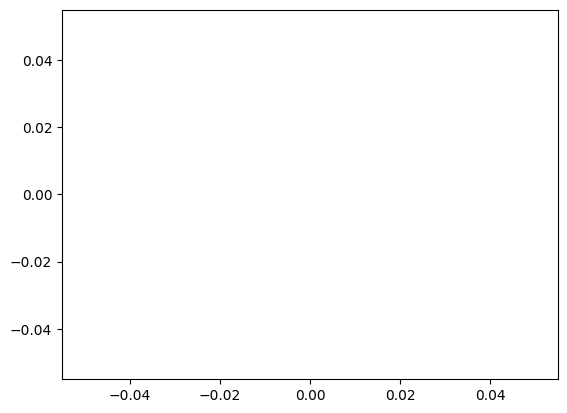

In [22]:
plt.plot(losses)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'losses' is your array of floats
losses = np.array(losses)  # Replace with your actual array if not already a NumPy array

# Calculate the window size, which is 10% of the length of the losses array
window_size = int(len(losses) * 0.1)
if window_size < 1:
    window_size = 1  # Ensure the window size is at least 1

# Calculate the rolling average using NumPy's convolution function and a uniform filter
rolling_average = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

# Plot the original losses
plt.plot(losses, label='Original Losses')

# Plot the rolling average. Note that the rolling average will be shorter than the original array.
# To align it with the original array, you'll need to decide how to handle the edges.
# Here, we're starting the rolling average from the midpoint of the window.
adjusted_index = (window_size - 1) // 2
plt.plot(range(adjusted_index, adjusted_index + len(rolling_average)), rolling_average, label='Rolling Average')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses and Rolling Average')
plt.legend()

# Show the plot
plt.show()


ValueError: v cannot be empty